<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

# Moment-Curvature: Steel W-Section

In this notebook, the objective is to analyze the elasto-plastic behavior of a steel section. More specifically, I want to calculate the bending capacity of a W-section at various curvatures. Let's begin by importing a few modules into our notebook.

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import pandas as pd

import os
import sys
sys.path.append(os.path.abspath("../.."))
from assets.modules.materials import Material, BilinearA992Steel, BilinearA36Steel
from assets.modules.shapes import *

## Define Steel Material

The steel material used here are elasto-plastic bilinear model with strain hardening. The strain hardening is defined as $\alpha=0.01$ which helps us to define the post-yield modulus as

$$E = \alpha E_o = \alpha \times 29000\ ksi$$

The stress-strain curves for ASTM A36 and A992 steels are defined as follows.

In [23]:
def plot_stress_strain_curves(materials:list[Material], figsize:tuple=(6, 4)):
    plt.figure(figsize=figsize)
    
    for mat in materials:
        eps_u = mat.eps_u
        strain = np.linspace(-eps_u, eps_u, 1000) 
        stress = mat.stress(strain)
        plt.plot(strain, stress/1e3, label=f"{mat.name} [alpha={mat.alpha}]")

    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.xlabel("Strain (ε) [in/in]")
    plt.ylabel("Stress (σ) [ksi]")
    plt.legend()  
    plt.title("Stress-Strain Curve")
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

Steel Material: A992, fy: 50000.0 psi, fu: 65000.0 psi, E: 29000000.0 psi, eps_y: 1.72e-03, eps_u: 5.34e-02, alpha: 0.01
Steel Material: A36, fy: 36000.0 psi, fu: 58000.0 psi, E: 29000000.0 psi, eps_y: 1.24e-03, eps_u: 7.71e-02, alpha: 0.01


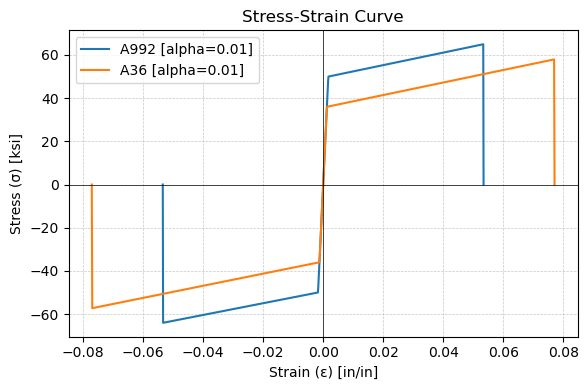

In [24]:

a992 = BilinearA992Steel()
a36 = BilinearA36Steel()

print(a992)
print(a36)

plot_stress_strain_curves([a992, a36])


Note that for W-sections, the prefrred material is A992 per AISC 360.

:::{note}

ASTM A992 Steel
* $F_y=50\ ksi$
* $F_u=65\ ksi$

:::

In [4]:
STRAIN_HARDENING = 0.01
STL = BilinearA992Steel(alpha=STRAIN_HARDENING)

## Define Section

For the purpose of this example, I will use W14X68 from AISC 360 manual with the following geometric properties is US units.

In [5]:
SEC = AISCShape('W14X68')
sec_df = SEC.props(as_dataframe=True)

sec_df[['A', 'd', 'tw', 'bf', 'tf', 'Ix', 'Iy', 'Sx', 'Sy', 'Zx', 'Zy', 'rx', 'ry']]

,A,d,tw,bf,tf,Ix,Iy,Sx,Sy,Zx,Zy,rx,ry
AISC_Manual_Label,,,,,,,,,,,,,
W14X68,20.0,14,0.415,10,0.72,722.0,121.0,103.0,24.2,115.0,36.9,6.01,2.46


## Moment-Curvature Calculation

To calculate moment curvature, I follow these steps:

1. Assume a value for the curvature.
2. Assume the location of the neutral axis where the strain and stress are zero. 
3. Build the strain diagram assuming Euler-Bernoulli beam theory.
4. Calculate the stress diagram using the strain diagram and the material properties (i.e., the stress-strain curve).
5. Calculate the internal forces induced by the stress.
6. Check whether force equilibrium is satisfied. If not, return to step 2 and try a new location for the neutral axis.
7. Calculate the induced internal moment.

<img src="../../assets/img/structure/moment_curvature/moment_curvature_01.png" alt="Moment-curvature Steps">

In this example, I assume bending about major principal axis of the W-section. Since W-sections are symmetric about both axis, and the section is under pure bending, the neutral axis passes through the geometric centroid of the section. So there is no need for the trial-error explained above.

:::{note}

__Euler-Bernoulli Beam Theory__

1. Plane sections remains plane at bending.
2. Sections normal to the neutral axis remains normal after bending.

Other beam theories include _Timoshenko beam theory_.

:::

<img src="../../assets/img/structure/moment_curvature/moment_curvature_02.jpg" alt="Euler-Bernoulli Beam Theory" width=800>

I have prepared `get_force` and `get_moment` functions to facilitate computing the internal force and moment.

In [6]:
def get_force(curv:float, sec:AISCShape, mat:Material):
    sec_props = sec.props()
    d, tf, tw, bf = sec_props['d'], sec_props['tf'], sec_props['tw'], sec_props['bf']
    
    y = np.linspace(-d/2, d/2, 1000).reshape(1, -1)
    delta_y = d / y.shape[1]
    eps = curv * y
    sigma = mat.stress(eps)
    
    return np.where(abs(y) > (d / 2 - tf), sigma * bf * delta_y, sigma * tw * delta_y)


def get_moment(curv:float, sec:AISCShape, mat:Material):
    d = sec.props()['d']
    force = get_force(curv, sec, mat)
    y = np.linspace(-d/2, d/2, 1000).reshape(1, -1)
    return np.sum(force * y, axis=1)

Now, assuming the outer most fiber of the section (the exterior edges of the top and bottom flange) attained the yield strain, let's compute the curvature and moment. Note that here, I am deviating a little bit from the steps I mentioned earlier. Instead of assuming the curvature and the location of the neutral axis, I assume the maximum value of the normal strain. Here are the results.

In [20]:
# Strain at the outter most fiber
eps_t = STL.eps_y

# Section curvature corresponding to the strain at the outer most fiber
d = SEC.props()['d']
curv_y = eps_t / (0.5 * d)
print(f"Curvature at yield (\u03BAy): {curv_y:.2e} 1/in")

M_y = get_moment(curv_y, SEC, STL)
print(f"Moment at yield: {M_y[0]/1e3/12:.0f} kip-ft")

Curvature at yield (κy): 2.46e-04 1/in
Moment at yield: 424 kip-ft


In [161]:
def draw_wsec(ax:axes.Axes, sec: AISCShape):
    sec_props = sec.props()
    d, tf, tw, bf = sec_props['d'], sec_props['tf'], sec_props['tw'], sec_props['bf']

    bottom_flange = patches.Rectangle((-bf / 2, - d / 2), bf, tf, facecolor='grey', alpha=0.5, edgecolor='black', linewidth=.5)
    web = patches.Rectangle((-tw/2, tf - d / 2), tw, d - 2 * tf, facecolor='grey', alpha=0.5, edgecolor='black', linewidth=.5)
    top_flange = patches.Rectangle((-bf / 2, d - tf - d/2), bf, tf, facecolor='grey', alpha=0.5, edgecolor='black', linewidth=.5)
    
    for part in [bottom_flange, web, top_flange]:
        ax.add_patch(part)

    ax.set_xlim(-bf, bf)
    ax.set_ylim(-d / 2, d / 2)
    ax.axis('off')
    # ax.set_aspect('auto')
    return ax
    
    
def plot_stress(ax: axes.Axes, curv:float, sec:AISCShape, mat:Material, figsize:tuple=(4, 5)):
    d = sec.props()['d']
    y = np.linspace(-d/2, d/2, 1000)
    eps = curv * y
    sigma = mat.stress(eps)/1e3
    tension = np.clip(sigma, 0, None)
    compression = np.clip(sigma, None, 0)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.plot(sigma, y, color="black")
    ax.fill_betweenx(y, 0, tension, color="blue", alpha=0.2)
    ax.fill_betweenx(y, 0, compression, color="red", alpha=0.2)
    ax.set_xlabel("Stress (σ) [ksi]")
    ax.set_ylabel("Distance from neutral axis, y [in]")
    ax.set_title(f"Stress Distribution in {sec.label}\n(\u03BA = {curv:.2e} 1/in)")
    ax.grid(True)
    
    ax_sec = ax.twiny()
    ax_sec = draw_wsec(ax_sec, sec)
    ax_sec.set_ylim(ax.get_ylim())
    
    return ax, ax_sec




And here is the stress digram. Recall that I assumed the exterior exdges of the top and bottom flange attained yield strain, $\epsilon_y$. As a result, the stress at the top and bottom are at $\sigma_y=50\ ksi$. Alos note that the neutral axis passes throught the section centroid. Since the stress diagram as well as the section are symmetric, the foce equilibrium is satisfied.

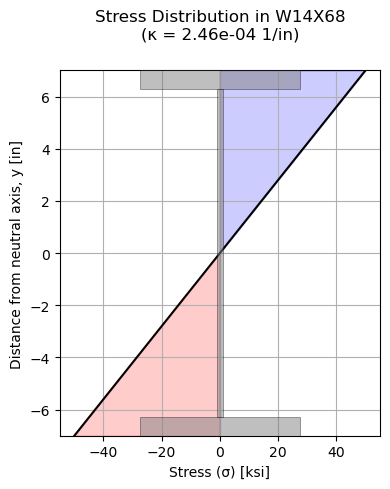

In [163]:
fig, ax = plt.subplots(figsize=(4, 5))
plot_stress(ax, curv_y, SEC, STL)
plt.tight_layout()
plt.show()

Now that I am able to develpe the stress diagram correctly, I can use that concept to define `w_sec_moment_curvature` function to generate the data points needed to plot the moment-curvature curve. The yield moment capacity, $M_y$ and plastic moment capacity, $M_p$ can be obtained as

$$M_y = S_x F_y = 103 \times (\tfrac{1\ ft}{12\ in}) \times 50 = 429\ kip-ft$$
$$M_p = Z_x F_y = 115 \times (\tfrac{1\ ft}{12\ in}) \times 50 = 479\ kip-ft$$

where

* $S_x$ and $Z_x$ are the elastic and plastic section modulus about the strong axis
* $M_y$ is the yield moment capacity assuming the outer most steel fibers are at the onset of yielding
* $M_p$ is the plastic moment capacity assuming the entire section attained the yield stress. Here I used AISC 360-22: Equation F2-1 to calculate the $M_p$. The effect of strain hardening is conservatively disregarded, and elastic-perfectly plastic stress-strain model is considered.

In [39]:
def w_sec_moment_curvature(sec:AISCShape, mat:Material, max_curv: float):   
    sec_props = sec.props() 
    d, tf, tw, bf = sec_props['d'], sec_props['tf'], sec_props['tw'], sec_props['bf']
    
    curv = np.linspace(0, max_curv, 1000).reshape(-1, 1)
    y = np.linspace(-d/2, d/2, 1000).reshape(1, -1)
    delta_y = d / y.shape[1]
    
    eps = np.dot(curv, y)
    sigma = mat.stress(eps)
    force = np.where(abs(y) > (d / 2 - tf), sigma * bf * delta_y, sigma * tw * delta_y)
    moment = np.sum(force * y, axis=1) # moment about the centroid
  
    return {
        "moment": moment,
        "curvature": curv.flatten(), 
        "y": y, 
        "stress": sigma, 
        "force": force
    }    

In [ ]:
MAX_CURV = 1.5e-2

data = w_sec_moment_curvature(SEC, STL, MAX_CURV)

M_max = data['moment'].max()/1e3/12 # kip-ft, max moment capacity
curv_max = data['curvature'][data['moment'].argmax()] # 1/in, curvature at max moment capacity

M_y = SEC.props()['Sx'] * STL.fy/1e3/12 # kip-ft, yield moment capacity
M_p = SEC.props()['Zx'] * STL.fy/1e3/12 # kip-ft, plastic moment capacity


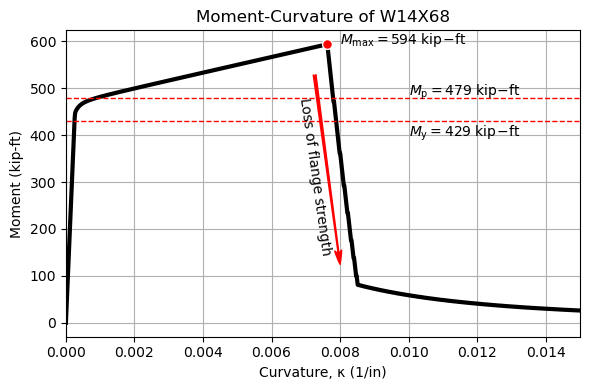

In [283]:
plt.figure(figsize=(6, 4))
plt.plot(data["curvature"], data["moment"]/1e3/12, color="black", linewidth=3, label=SEC.label)
plt.scatter(curv_max, M_max, color="red", edgecolor='white', marker="o", s=50, label="Max Moment", zorder=10)
plt.axhline(y=M_y, color="red", linestyle="--", linewidth=1, label="Yield Moment")
plt.axhline(y=M_p, color="red", linestyle="--", linewidth=1, label="Plastic Moment")
plt.xlim(0, MAX_CURV)
plt.xlabel(f"Curvature, \u03BA (1/in)")
plt.ylabel("Moment (kip-ft)")
plt.title(f"Moment-Curvature of {SEC.label}")
plt.annotate(rf"$M_{{\mathrm{{max}}}} = {M_max:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(curv_max, M_max), xytext=(1.05*curv_max, M_max), fontsize=10, ha='left', va='baseline', color='black')
plt.annotate(rf"$M_{{\mathrm{{p}}}} = {M_p:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(0.010, M_p), xytext=(0.010, 1.01*M_p), fontsize=10, ha='left', va='baseline', color='black')
plt.annotate(rf"$M_{{\mathrm{{y}}}} = {M_y:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(0.010, M_y), xytext=(0.010, 0.99*M_y), fontsize=10, ha='left', va='top', color='black')
arrowprops = dict(arrowstyle="fancy,head_length=1,head_width=0.5,tail_width=.2", connectionstyle="arc3,rad=0.0", color="red")
plt.annotate("", xy=(1.05*curv_max, 0.2*M_max), xytext=(0.95*curv_max, 0.9*M_max), arrowprops=arrowprops, color='black', zorder=9)
plt.annotate("Loss of flange strength", xy=(1.05*curv_max, 0.2*M_max), xytext=(1.02*curv_max, 0.25*M_max), rotation=-82, fontsize=10, ha='right', va='baseline', color='black', zorder=9)
plt.grid(True)
plt.tight_layout()
plt.show()

The moment capacity drops significantly after reaching its max due to loosing the contribution of the flanges. The maximum moment capacit is higher than the plastic moment capacity because of the strain hardening. If repeat the calculation using A992 steel without strain hardening ($\alpha=0.0$), this would be the outcome.

In [157]:
STL_0 = BilinearA992Steel(alpha=0.0)
data_0 = w_sec_moment_curvature(SEC, STL_0, MAX_CURV)
M_max0= data_0['moment'].max()/1e3/12 # kip-ft, max moment capacity
curv_max0 = data_0['curvature'][data_0['moment'].argmax()] # 1/in, curvature at max moment capacity

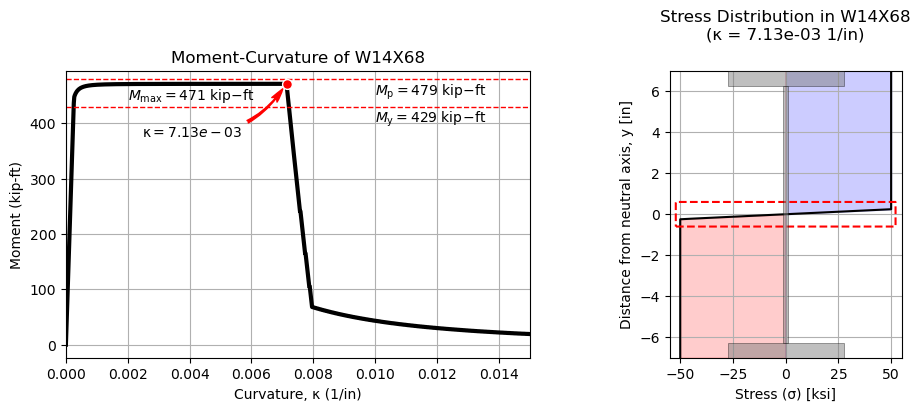

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), width_ratios=(2, 1), gridspec_kw={'wspace': 0.2}, constrained_layout=True)

ax[0].plot(data_0["curvature"], data_0["moment"]/1e3/12, color="black", linewidth=3, label=SEC.label)
ax[0].scatter(curv_max0, M_max0, color="red", edgecolor='white', marker="o", s=50, label="Max Moment", zorder=10)
ax[0].axhline(y=M_y, color="red", linestyle="--", linewidth=1, label="Yield Moment")
ax[0].axhline(y=M_p, color="red", linestyle="--", linewidth=1, label="Plastic Moment")
ax[0].set_xlim(0, MAX_CURV)
ax[0].set_xlabel(f"Curvature, \u03BA (1/in)")
ax[0].set_ylabel("Moment (kip-ft)")
ax[0].set_title(f"Moment-Curvature of {SEC.label}")
ax[0].annotate(rf"$M_{{\mathrm{{max}}}} = {M_max0:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(0.002, M_max0), xytext=(0.002, 0.99*M_max0), fontsize=10, ha='left', va='top', color='black')
ax[0].annotate(rf"$M_{{\mathrm{{p}}}} = {M_p:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(0.010, M_p), xytext=(0.010, 0.99*M_p), fontsize=10, ha='left', va='top', color='black')
ax[0].annotate(rf"$M_{{\mathrm{{y}}}} = {M_y:.0f}\ \mathrm{{kip\!-\!ft}}$", xy=(0.010, M_y), xytext=(0.010, 0.99*M_y), fontsize=10, ha='left', va='top', color='black')
arrowprops = dict(arrowstyle="fancy,head_length=1,head_width=0.5,tail_width=.2", connectionstyle="arc3,rad=0.3", color="red")
ax[0].annotate(rf"${{\mathrm{{\kappa}}}}={curv_max0:.2e}$", xy=(0.99*curv_max0, 0.99*M_max0), xytext=(0.8*curv_max0, 0.8*M_max0), arrowprops=arrowprops, fontsize=10, ha='right', va='baseline', color='black', zorder=9)
ax[0].grid(True)

ax[1], _ = plot_stress(ax[1], curv_max0, SEC, STL_0)
rounded_box = patches.FancyBboxPatch(
    (-52, -0.5), 104, 1,  # (x, y), width, height
    boxstyle="round,pad=0.1",
    edgecolor="red",
    facecolor="none",
    linestyle="--",
    linewidth=1.5,
    alpha=1.0,
    zorder=5
)
ax[1].add_patch(rounded_box)

plt.show()

So close! The maximum calculated moment in the digram is slightly lower than the plastic moment capacity. This is because in our moment-curvature calculation, the strain at the neutral axis is alway zero and so the stress. Consequently, the stress at the neutral axis never attains $F_y$ in our calculation, but in $M_p$ calculation does. That is why $M_{max}$ is slihgtly lower than the $M_p$.

## Effect of Section Curvature on Stress Distribution

In order to better understand the curvature-stress relationship, let's first plot the stress distribution across the section at various curvatures ($\kappa$). I will create the stress plots for 32 different curvature values between $\kappa = 0$ and $\kappa = $ `MAX_CURV` using the original steel material with strain hardening.

In [279]:
def select_curvatures(arr:np.ndarray, threshold, nPoints:int, ratio:float):
    # Find the index in arr closest to the threshold
    idx_closest = np.argmin(np.abs(arr - threshold))
    
    # Compute the number of points before and after the threshold
    pre_nPoints = int(nPoints * ratio)
    post_nPoints = nPoints - pre_nPoints

    # Indices before and after, at given interval
    pre_indices = np.linspace(0, idx_closest, pre_nPoints, dtype=int)
    post_indices = np.linspace(idx_closest + 2 , arr.shape[0] - 1, post_nPoints, dtype=int)

    # Join the two arrays of indices
    selected_indices = np.concatenate((pre_indices, post_indices))

    return selected_indices


def plot_section_stress(nPoints:int, ncols:int, curv:np.ndarray, y:np.ndarray, sigma:np.ndarray, yield_curv: float, ratio:float, figsize:tuple=(15, 10)):
    
    # Get the indices of the selected curvatures
    selected_indices = select_curvatures(curv, yield_curv, nPoints, ratio)
    
    # Calculate number of rows in the plot
    nrows = int(np.ceil(nPoints / ncols))
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
    
    ax = ax.flatten()
    y = y.flatten()
    
    for i, idx in enumerate(selected_indices):
        ax[i].plot(sigma[idx]/1e3, y, color="black", label=f"\u03BA = {curv[idx]:.2e} 1/in")
        tension = np.clip(sigma[idx]/1e3, 0, None)
        compression = np.clip(sigma[idx]/1e3, None, 0)
        ax[i].fill_betweenx(y, 0, tension, color="blue", alpha=0.2)
        ax[i].fill_betweenx(y, 0, compression, color="red", alpha=0.2)
        ax[i].text(
            0.5, 1.03, f"\u03BA = {curv[idx]:.2e} 1/in",
            transform=ax[i].transAxes,
            ha='center', va='bottom', fontsize=9
        )
        ax[i].set_xlabel("σ [ksi]")
        ax[i].grid(True)
        
        ax_sec = ax[i].twiny()
        ax_sec = draw_wsec(ax_sec, SEC)
        ax_sec.set_ylim(ax[i].get_ylim())
        ax_sec.set_ylabel("y [in]")
        
    for i in range(nPoints, len(ax)):
        fig.delaxes(ax[i])
    
    plt.suptitle(f"Stress Distribution in {SEC.label}")
    plt.tight_layout()
    plt.show()
    

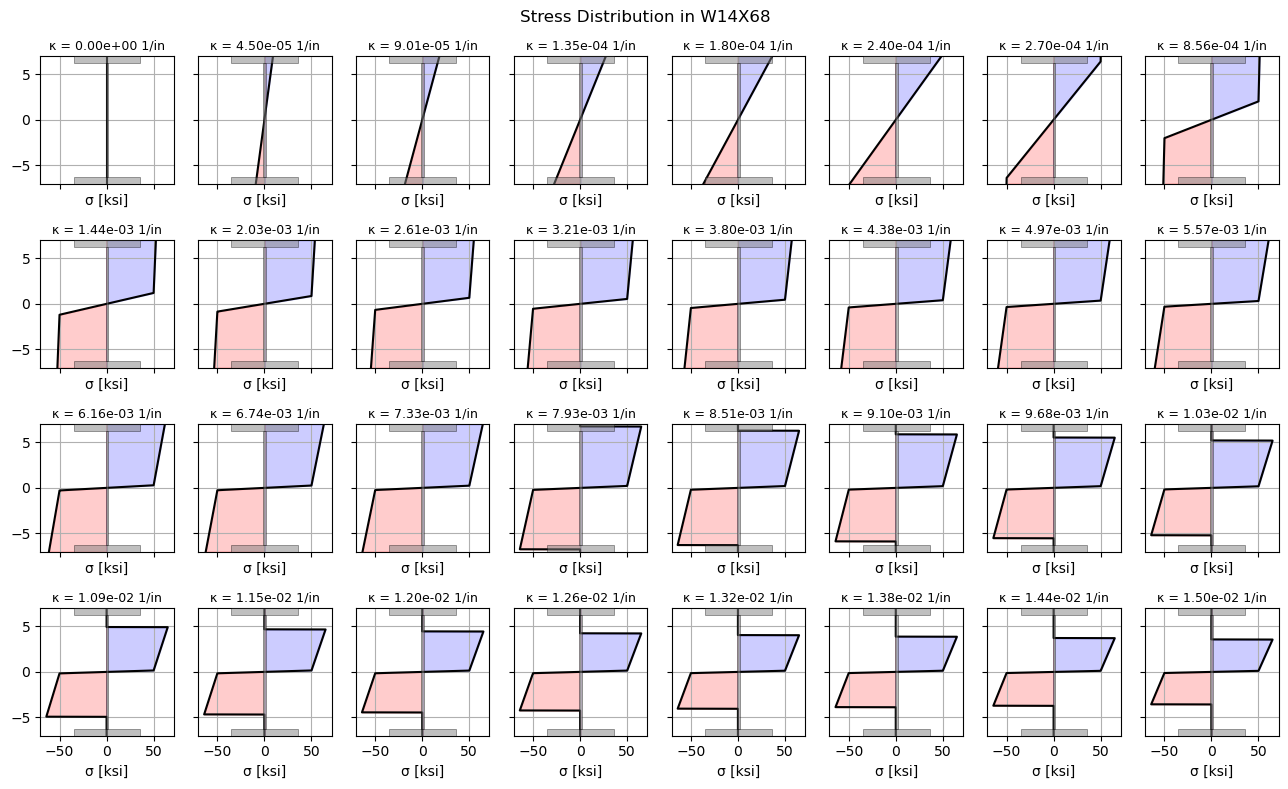

In [280]:
plot_section_stress(nPoints=32, ncols=8, curv=data["curvature"], y=data["y"], sigma=data["stress"], yield_curv=curv_y, ratio=0.2, figsize=(13, 8))

In the above plots, the vertical axis shows the height of section in inch, where zero is the neutral axis of the section. The horizontal axis shows the magnitude of the normal stress in section in ksi.

The curvature value of $\kappa=2.40 \times 10^{-4}\ \tfrac{1}{in}$ corresponds to onset of yielding in the top and bottom flanges. At $\kappa=7.33 \times 10^{-3}\ \tfrac{1}{in}$, alomst the entire section is yielded. Note that due to strain hardening, the normal stress at the tip of the flanges are greater than $\sigma_y=50 ksi$. From this point forward, apllying more moment causes the normal stress at the outter most fibers of the top and bottom flanges to drop to zero. This is because the normal strains at these fibers exceeds the ultimate strain, $\epsilon_u$ of the material. For instance at $\kappa=7.93 \times 10^{-3}\ \tfrac{1}{in}$, we have

$$\kappa = \frac{\epsilon}{y_{_{N.A.}}} \rightarrow \epsilon = \kappa \cdot y_{_{N.A.}}$$
$$\epsilon = 7.93 \times 10^{-3} \times 7.0 = 5.55 \times 10^{-2} > \epsilon_u = 5.34 \times 10^{-2}$$

Moving forward, at $\kappa=8.51 \times 10^{-3}\ \tfrac{1}{in}$, the normal stress in the entire top and bottom flanges drops to zero which causes a huge reduction in the moment capacity of the section as illustrated in the moment-curvature diagram.

In [281]:

def plot_combined_moment_curvature_with_stress(data:dict, sec:AISCShape, curvs:list, insets:list, inset_size: tuple):

    curvature = data["curvature"]
    moment = data["moment"]/1e3/12  # Convert lbs-in to kip-ft
    y = data["y"].flatten()
    sigma = data["stress"]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(curvature, moment, label=sec.label, color='black', linewidth=5)
    ax.set_xlabel(f"Curvature, \u03BA (1/in)")
    ax.set_ylabel("Moment (kip-ft)")
    ax.set_title(f"Moment-Curvature of {sec.label}")
    ax.grid(True)

    # Axis limits for normalization
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    i = 1
    for curv, inset in zip(curvs, insets):
        # Find the closest curvature index
        step = np.argmin(np.abs(curvature - curv))
        x_curv = curvature[step]
        y_moment = moment[step]
        ax.scatter(x_curv, y_moment, color='red', edgecolor='white', marker='o', s=75, zorder=20)
        
        # Annotate the data points with point numbers
        ax.annotate(f"{i}", xy=(x_curv, y_moment), xytext=(3, 6), textcoords='offset points', fontsize=11, weight='bold', color='red')
        i += 1
        
        # Normalize coordinates to [0, 1] in axes fraction
        x_norm = (x_curv - xlim[0]) / (xlim[1] - xlim[0])
        y_norm = (y_moment - ylim[0]) / (ylim[1] - ylim[0])

        # Inset size in axis fraction
        inset_w, inset_h = inset_size

        # Adjust placement to avoid overlapping
        inset_x = x_norm + inset[0]*inset_size[0]#- inset_w / 2
        inset_y = y_norm + inset[1]*inset_size[1]#0.03  # a little above the point

        # Avoid going out of bounds
        inset_x = np.clip(inset_x, 0, 1 - inset_w)
        inset_y = np.clip(inset_y, 0, 1 - inset_h)

        # Create inset axis
        inset_ax = ax.inset_axes([inset_x, inset_y, inset_w, inset_h])
        inset_ax.plot(sigma[step, :], y, color='red', linewidth=1)
        inset_ax.fill_betweenx(y, 0, sigma[step, :], color="red", alpha=0.2)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        # inset_ax.set_facecolor("white")
        inset_ax.patch.set_alpha(0)
        for spine in inset_ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()


To better appreciate the relationship among the curvature, stress, and moment, I have created another plot illustrating the stress distribution at key points along the moment-curvature diagram. A few take-aways from this figure are:

* The onset of yielding in the section corresponds to the transition from linear to nonlinear (point 1 to 2) in the moment-curvature diagram.
* Moving along the curve, from point 2 to 3 and 4, progression of plastification deep into the web causes the increase in the moment capacity.
* Point 4 corresponds to the maximum moment capacity. At this point almost the entire corss section attains the yield stress, and the strain at the tip of the flanges reaches the ultimate strain ($\epsilon_u$).
* Moment capacity drops significantly as the curvature increase further from point 4 to 5. This is attributed to loss of flange contribution.
* After point 5, the minimal moment capacity is due to the web contribution only. This is the softening region which corresponds to large curvatures.

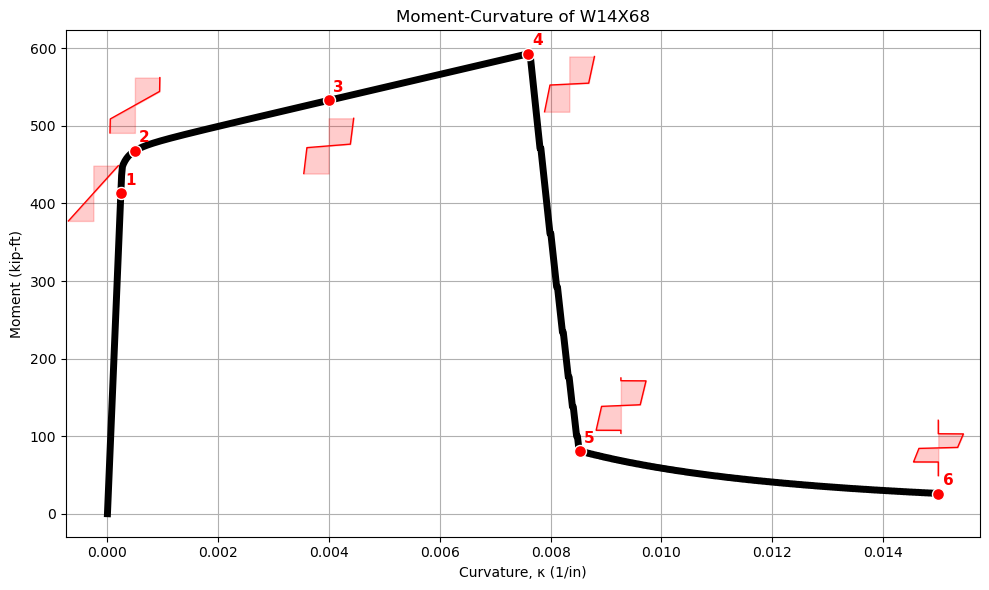

In [282]:
S = (0.06, 0.12)  # Inset size relative to main axes
CURVS = [curv_y, 0.5e-3, 4.0e-3, 7.6e-3, 8.53e-3, MAX_CURV]
INSETS = [(-1, -0.5), (-0.5, 0.25), (-0.5, -1.25), (0.25, -1), (0.25, 0.25), (-0.5, 0.25)]
plot_combined_moment_curvature_with_stress(data, SEC, CURVS, INSETS, inset_size=S)